<a href="https://colab.research.google.com/github/Salekin-13/BanglaHandwriting/blob/main/BanglaWriting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Aug 28 21:15:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [3]:
import torch
print(torch.cuda.get_device_name(0))

Tesla T4


In [4]:
!rm -rf /content/BanglaHandwriting

In [5]:
!git clone https://github.com/Salekin-13/BanglaHandwriting.git

Cloning into 'BanglaHandwriting'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 239 (delta 3), reused 0 (delta 0), pack-reused 231
Receiving objects: 100% (239/239), 47.29 MiB | 19.23 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [6]:
import os

# Set the current working directory to the immediate upper folder
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
%cd /content/BanglaHandwriting

/content/BanglaHandwriting


In [7]:
#!pip install pytorch_lightning==2.0.7
#!pip install boltons==23.0.0
#!pip install wandb==0.15.8

In [8]:
from data.B_iam_paragraphs import BIAMParagraphs
import numpy as np
import wandb

In [9]:
data = BIAMParagraphs()
data.setup()
print(data)

B_IAM Paragraphs Dataset
Num classes: 1350
Input dims : (1, 1000, 1000)
Output dims: (700, 1)
Train/val/test sizes: 25, 7, 7



In [10]:
x, y = next(iter(data.test_dataloader()))
print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([7, 1, 1000, 1000]) torch.float32
torch.Size([7, 700]) torch.int64


In [11]:

def show(y):
    y = y.detach().cpu().numpy().squeeze().tolist() # bring back from accelerator if it's being used
    return "".join((data.mapping[token_id]) for token_id in y).replace("<P>", "")

<S>কিন্তু শিল্পায়ন, নগারায়ণ ও মানুষের
অর্থনৈতিক জীবনধারার পরিবর্তনের ফলে
একান্নবতী পরিবার গুলো ভেঙে গিয়ে
ছোট ছোট পবিবারের পরিণত হচ্ছে।
স্বামী-স্ত্রী, ছেলেমেয়ে ও বড়জোর কাজের
লোক নিয়ে এ পরিবার ব্যবস্থায় বৃদ্ধ
বাবা-মা'রা শ্বসুর-শাশুড়ির স্থান
থাকছে না, কিংবা তারা কোনঠাসা
হয়ে বাস করেছেন। তাদের দেখাশুনা
বা অসুখ বিসুখ-<G>সেবা যত্নের
লোকের অভাব ঘটেছে। এসব পারিবারিক
সমস্যা প্রবীনদের নানা ধরনের মনস্তাত্তিক
সমস্যার সৃষ্টি করছে। প্রবীরা এইসব
পারিবারিক সমস্যার কারণে এক ধরনের<E>


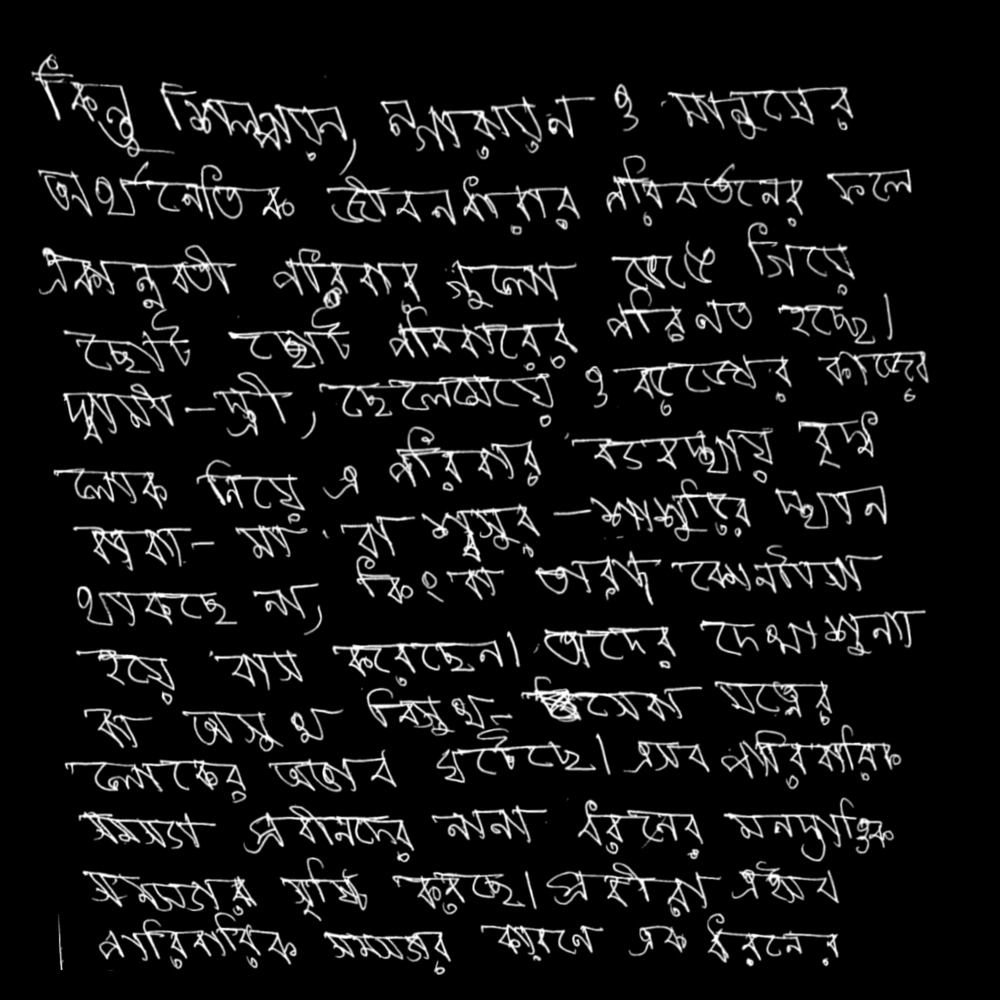

In [12]:
rand_i = np.random.randint(len(data.data_train))
img, label = data.data_train[rand_i]
print(show(label))
wandb.Image(img).image


In [13]:
import torch

start_index = data.inverse_mapping["<S>"]
end_index = data.inverse_mapping["<E>"]
padding_index = data.inverse_mapping["<P>"]

device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
from models.resnet_transformer import ResnetTransformer
model = ResnetTransformer(data_config=data.config()).to(device)

In [19]:
from lit_models.metrics import CharacterErrorRate
import torch.nn as nn
import warnings

num_epochs = 100

criterion = nn.CrossEntropyLoss(ignore_index=padding_index)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

ignore_tokens = [start_index, end_index, padding_index]
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    val_cer = CharacterErrorRate(ignore_tokens)
    test_cer = CharacterErrorRate(ignore_tokens)


In [20]:
def teacher_forward(x, y):
        x = model.encode(x)
        output = model.decode(x, y)  # (Sy, B, C)
        return output.permute(1, 2, 0)  # (B, C, Sy)

In [21]:
train_dataloader = data.train_dataloader()
val_dataloader = data.val_dataloader()
test_dataloader = data.test_dataloader()

In [ ]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for x,y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        logits = teacher_forward(x, y[:, :-1])
        loss = criterion(logits, y[:, 1:])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for x,y in val_dataloader:  # Use test_dataloader for testing
            x = x.to(device)
            y = y.to(device)
            logits = teacher_forward(x, y[:, :-1])
            val_loss = criterion(logits, y[:, 1:])
            preds = model(x)
            val_cer(preds, y)
            print(f"epoch: {epoch}, val loss: {val_loss}, val_cer:{val_cer.compute()}")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


epoch: 0, val loss: 4.89501953125, val_cer:1.6884315013885498
epoch: 1, val loss: 4.666722774505615, val_cer:1.680269718170166
epoch: 2, val loss: 4.180349349975586, val_cer:1.6540099382400513
epoch: 3, val loss: 3.8004508018493652, val_cer:1.6488643884658813
epoch: 4, val loss: 4.101920127868652, val_cer:1.6508162021636963
epoch: 5, val loss: 3.7837116718292236, val_cer:1.6425951719284058
epoch: 6, val loss: 3.728222370147705, val_cer:1.6367231607437134
epoch: 7, val loss: 3.697967767715454, val_cer:1.6323189735412598
epoch: 8, val loss: 3.678295373916626, val_cer:1.6288936138153076
epoch: 9, val loss: 3.684638500213623, val_cer:1.6261533498764038
epoch: 10, val loss: 3.7168538570404053, val_cer:1.6239112615585327
epoch: 11, val loss: 3.7265655994415283, val_cer:1.6220427751541138
epoch: 12, val loss: 3.700122356414795, val_cer:1.6204618215560913
epoch: 13, val loss: 3.6982431411743164, val_cer:1.6191067695617676
epoch: 14, val loss: 3.6969151496887207, val_cer:1.6179323196411133
epoc